# Tutorial - Latent space analysis using PCA

## 1. Import requirements

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import tqdm
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA

In [2]:
sys.path = [os.path.abspath(os.path.join(os.getcwd(), os.pardir))] + sys.path

In [3]:
from COMA.dataset import TrainingSmilesDataset
from COMA.vae import SmilesAutoencoder
from COMA.properties import similarity

## 2. Configure GPU (if available)

In [4]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

## 3. Specify a target property

In [5]:
PROPERTY_NAME = "qed"

## 4. Set directories (for inputs and outputs)

In [6]:
input_data_dir = os.path.abspath(os.path.join(os.pardir, "DATA", PROPERTY_NAME))
input_ckpt_dir = f"outputs_2-1_{PROPERTY_NAME.upper()}_pretraining"

In [7]:
output_dir = f"outputs_2-3_{PROPERTY_NAME.upper()}_latent_space_analysis"
if not os.path.exists(output_dir):
    os.mkdir(output_dir)

## 5. Set file names

In [7]:
filepath_train = os.path.join(input_data_dir, "rdkit_train_triplet.txt")

In [8]:
filepath_ckpt     = os.path.join(input_ckpt_dir, "checkpoints.pt")
filepath_configs  = os.path.join(input_ckpt_dir, "configs.csv")
filepath_char2idx = os.path.join(input_ckpt_dir, "char2idx.csv")

In [9]:
filepath_scatter = os.path.join(output_dir, "scatter.png")
filepath_box     = os.path.join(output_dir, "box.png")

## 6. Load a training dataset

In [10]:
dataset = TrainingSmilesDataset(filepath_train, filepath_char2idx=filepath_char2idx, device=device)

## 7. Load a pretrained generator of COMA

In [11]:
## Model configuration
model_configs = {"hidden_size"    :None,
                 "latent_size"    :None,
                 "num_layers"     :None,
                 "vocab_size"     :None,
                 "sos_idx"        :None,
                 "eos_idx"        :None,
                 "pad_idx"        :None,
                 "device"         :device,
                 "filepath_config":filepath_configs}

## Model initialization
generator = SmilesAutoencoder(**model_configs)

## Load pretrained model
generator.load_model(filepath_ckpt)

## 8. Calculate latent vectors

In [12]:
latent_vectors_src = []
latent_vectors_tar = []

for batch in tqdm.tqdm(DataLoader(dataset, batch_size=100, shuffle=False, drop_last=False, pin_memory=use_cuda)):
    len_src = batch["length_s"]
    len_tar = batch["length_t"]
    smi_src = dataset.encode(batch["smiles_s"], batch["length_s"].max())
    smi_tar = dataset.encode(batch["smiles_t"], batch["length_t"].max())
    
    mean_src, logvar_src = generator.transform(smi_src, len_src)
    mean_tar, logvar_tar = generator.transform(smi_tar, len_tar)
    
    z_src = mean_src + np.random.randn(*logvar_src.shape) * np.exp(0.5 * logvar_src)
    z_tar = mean_tar + np.random.randn(*logvar_tar.shape) * np.exp(0.5 * logvar_tar)
    
    latent_vectors_src.append(z_src)
    latent_vectors_tar.append(z_tar)
    
latent_vectors_src = np.concatenate(latent_vectors_src)
latent_vectors_tar = np.concatenate(latent_vectors_tar)

100%|██████████| 17662/17662 [03:19<00:00, 88.74it/s]


## 9. Randomly select 10 pairs

In [13]:
number_of_samples = 10
idx = np.random.choice(len(dataset), number_of_samples)

samples_src = latent_vectors_src[idx]
samples_tar = latent_vectors_tar[idx]

smiles_src = dataset.df.loc[idx, "smiles_src"]
smiles_tar = dataset.df.loc[idx, "smiles_tar"]

labels_src = ["S1", "S2", "S3", "S4", "S5", "S6", "S7", "S8", "S9", "S10"]
labels_tar = ["T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T10"] 

## 10. Principal component analysis

In [14]:
pca = PCA(n_components=2, random_state=2022)
pca = pca.fit(np.concatenate((samples_src, samples_tar)))

points_src = pca.transform(samples_src)
points_tar = pca.transform(samples_tar)

## 11. Visualise a scatter plot

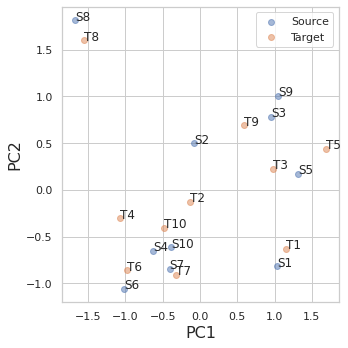

In [15]:
sns.set_theme(style='whitegrid')

fig, ax = plt.subplots(1,1,figsize=(5,5))

ax.scatter(points_src[:,0], points_src[:,1], marker="o", label="Source", alpha=0.5)
for label, (pos_x,pos_y) in zip(labels_src, points_src[:10]):
    ax.text(pos_x, pos_y, label, fontsize=12)

ax.scatter(points_tar[:,0], points_tar[:,1], marker="o", label="Target", alpha=0.5)
for label, (pos_x,pos_y) in zip(labels_tar, points_tar[:10]):
    ax.text(pos_x, pos_y, label, fontsize=12)

ax.legend(loc='best')

ax.set_xlabel("PC1", fontsize=16)
ax.set_ylabel("PC2", fontsize=16)

plt.tight_layout()
plt.savefig(filepath_scatter, dpi=300)
plt.show()

## 12. Compute the Euclidean distance and Tanimoto similarity for each pair

In [16]:
data_s_d = []

smiles_src = list(zip(labels_src, smiles_src, points_src[:,0], points_src[:,1]))
smiles_tar = list(zip(labels_tar, smiles_tar, points_tar[:,0], points_tar[:,1]))

for label_src, smi_src, pos_x_src, pos_y_src in smiles_src:
    for label_tar, smi_tar, pos_x_tar, pos_y_tar in smiles_tar:
        s = similarity(smi_src, smi_tar)
        d = np.sqrt((pos_x_src - pos_x_tar)**2 + (pos_y_src - pos_y_tar)**2)
        data_s_d.append((label_src,smi_src,label_tar, smi_tar, s, d))
        
df_sd = pd.DataFrame.from_records(data_s_d)
df_sd = df_sd.rename(columns={0:"Label(source)", 1:"SMILES(source)", 2:"Label(target)", 3:"SMILES(target)", 4:"Tanimoto Similarity", 5:"Euclidean Distance"})

df_sd.loc[df_sd.index[df_sd["Tanimoto Similarity"] >= 0.4], "Group"] = "Similar"
df_sd.loc[df_sd.index[df_sd["Tanimoto Similarity"] < 0.4], "Group"] = "Dissimilar"

## 13. Visualise a box plot (x-axis: Tanimoto, y-axis: Euclidean)

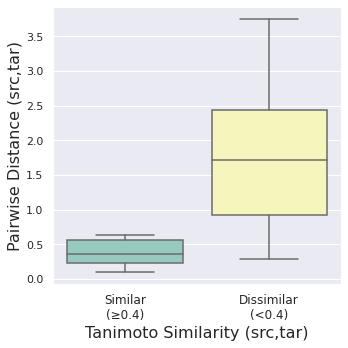

In [17]:
sns.set_theme(style='darkgrid')

fig, ax = plt.subplots(1,1,figsize=(5,5))

sns.boxplot(data=df_sd, x="Group", y="Euclidean Distance", ax=ax, palette=sns.color_palette("Set3"))

ax.set_xlabel("Tanimoto Similarity (src,tar)", fontsize=16)
ax.set_ylabel("Pairwise Distance (src,tar)", fontsize=16)

ax.set_xticklabels(["Similar\n(≥0.4)", "Dissimilar\n(<0.4)"], fontsize=12)

plt.tight_layout()
plt.savefig(filepath_box, dpi=300)
plt.show()